# Finite Element Analysis
Prepared by Dr Dimitris Karamitros, Senior Lecturer in Geotechnical Engineering.  
Delivered as part of *CENG300010 - Advanced Structural Analysis* (University of Bristol, 2023).  
<br>
This notebook will introduce you to the implementation of the Finite Element Method.  
It will focus on the simple case of rod elements that can only undertake tension and compresion.  
<br>
Note that the code could have been written more concisely, but it has been expanded to improve readability.  
<br>
*This is the full version, with comments and explanations.*

## Libraries
Finite Element Analysis requires basic linear algebra operations. The external library **numpy** will be imported to conduct these.  
It is also possible to use **scipy**, which offers additional functionality for integration, differential equations, eigenvalue problems and others.  
Nevertheless, **numpy** is sufficient for FEA.  
<br>
The **matplotlib.pyplot** library will also be imported to plot the obtained results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Pre-processing
First, we will define the structure to be analysed.

### Input Variables
Basic variables are initially defined.

In [2]:
E = 1
A = 1
L = 1
F = 1

### Mesh Definition
To define the finite element mesh, we need a list of nodes, a list of elements connecting these nodes, properties for these elements, supports, and applied loads.

**Nodes** will be defined in terms of their coordinates **[x,y]**.  
We will define node numbers as 1,2,3,... We will deal with Python indexing later.

In [3]:
Nodes = np.array([
    [0,0],
    [0,L],
    [L,0]])

In [4]:
# Count the number of nodes and degrees of freedom (DOFs):
nNodes = Nodes.shape[0]
nDOFs = 2*nNodes
print("Number of nodes = ",nNodes)
print("Number of DOFs = ",nDOFs)

Number of nodes =  3
Number of DOFs =  6


**Elements** will be defined in terms of starting and ending node, as **[node1,node2]**.  
Remember to follow the same node numbering as above.

In [5]:
Elements = np.array([
    [1,3],
    [2,3],
    [1,2]])

In [6]:
# Count the number of elements:
nElements = Elements.shape[0]
print("Number of elements = ",nElements)

Number of elements =  3


For each element, **properties** will be defined following the convention **[E,A]**.  
Remember to follow the same order of elements as above.

In [7]:
Properties = np.array([
    [E,A],
    [E,A],
    [E,A]])

**Supports** (applied displacements) will be defined following the convention [node, DOF (1 for x, 2 for y), displacement].

In [8]:
Supports = np.array([
    [1,1,0],
    [2,1,0],
    [2,2,0]])

In [9]:
# Count the number of supports:
nSupports = Supports.shape[0]
print("Number of supports = ",nSupports)

Number of supports =  3


**Loads** (applied forces) will be defined following the convention [node, direction (1 for x, 2 for y), load].  
Remember that *x* and *y* are positive towards the right and up, respectively.

In [10]:
Loads = np.array([
    [3,2,-F]])

In [11]:
# Count the number of loads:
nLoads = Loads.shape[0]
print("Number of loads = ",nLoads)

Number of loads =  1


### Plot Mesh
We will plot the mesh to confirm that everything has been defined correctly.

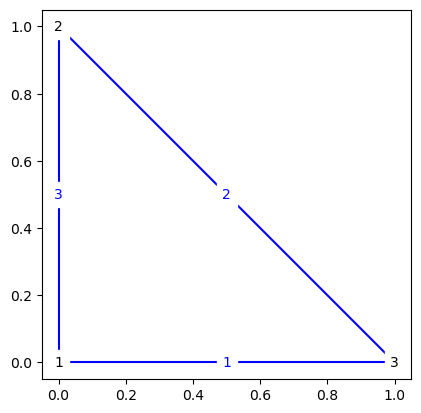

In [12]:
# Create empty figure and axes
fig1, ax1 = plt.subplots()
# Set apsect ratio x:y to 1:1
ax1.set_aspect(1)

# For each one of the elements
for iE,elem in enumerate(Elements):

    # Find Element Nodes
    node1 = elem[0]
    node2 = elem[1]
    
    # Find Node Coordinates
    # (we need to subtract 1 from node numbers, because we counted as 1,2,3,... while Python counts as 0,1,2,...)
    # (we use 0 for y and 1 for y directions)
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]

    # Plot a Line
    ax1.plot([x1,x2],[y1,y2], color='blue')

    # Annotate the element number
    # (we need to add 1 because Python starts counting at 0)
    ax1.annotate(iE+1, xy=((x1+x2)/2,(y1+y2)/2), ha='center', va='center', color='blue', backgroundcolor='1')

# For each one of the nodes
for iN,node in enumerate(Nodes):

    # Find Node Coordinates
    x = node[0]
    y = node[1]

    # Annotate the node number
    # (we need to add 1 because Python starts counting at 0)
    ax1.annotate(iN+1, xy=(x,y), ha='center', va='center', color='black', backgroundcolor='1')

## Stiffness Matrix Assembly
First, define the **Global Stiffness Matrix K**. It should be square, with dimensions equal to *nDOFs x nDOFs*.

In [13]:
K = np.zeros((nDOFs,nDOFs))

Then, for each element, compute the **Element Stiffness Matrix ke**.  
For rod elements, in the *local coodrinate system*, the Element Stiffness Matrix is:
$$ [k_e] = \frac{EA}{L} \left[ \begin{array}{cccc} 1&0&-1&0 \\ 0&0&0&0 \\ -1&0&1&0 \\ 0&0&0&0 \end{array} \right] $$
The Element Stiffness Matrix in *global coordinates* is:
$$ [K_e] = [T]^T [k_e] [T] $$
where the *Coordinate Transform Matrix* is:
$$ [K_e] = \frac{EA}{L} \left[ \begin{array}{cccc} c&s&0&0 \\ -s&c&0&0 \\ 0&0&c&s \\ 0&0&-s&c \end{array} \right] $$

In [14]:
# For each one of the elements
for iE,elem in enumerate(Elements):

    # Find Element Nodes
    node1 = elem[0]
    node2 = elem[1]
    
    # Find Node Coordinates
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]

    # Compute Element Stiffness Matrix in Local Coordinates
    E = Properties[iE,0]
    A = Properties[iE,1]
    L = np.sqrt((x2-x1)**2+(y2-y1)**2)
    ke = (E*A/L) * np.array([
        [1,0,-1,0],
        [0,0,0,0],
        [-1,0,1,0],
        [0,0,0,0]])

    # Compute Coordinate Transformation Matrix
    theta = np.arctan2((y2-y1),(x2-x1))
    c = np.cos(theta)
    s = np.sin(theta)
    T = np.array([
        [c,s,0,0],
        [-s,c,0,0],
        [0,0,c,s],
        [0,0,-s,c]])
   
    # Compute Element Stiffness Matrix in Global Coordinates
    Ke = T.T @ ke @ T
    print("\nElement", iE+1, "Stiffness Matrix =")
    with np.printoptions(precision = 3, suppress = True):
        print(Ke)
    
    # Assemble Global Stiffness Matrix
    # Observe that for node = 1,2,3,... the expression 2*(node-1) gives 0,2,4,...
    # Similarly, for node = 1,2,3,... the expression 2*node gives 1,3,5,...    
    K[2*(node1-1):2*node1 , 2*(node1-1):2*node1] += Ke[0:2,0:2]
    K[2*(node1-1):2*node1 , 2*(node2-1):2*node2] += Ke[0:2,2:4]
    K[2*(node2-1):2*node2 , 2*(node1-1):2*node1] += Ke[2:4,0:2]
    K[2*(node2-1):2*node2 , 2*(node2-1):2*node2] += Ke[2:4,2:4]

# Print the final matrix
print("\nGlobal Stiffness Matrix =")
with np.printoptions(precision = 3, suppress = True):
    print(K)


Element 1 Stiffness Matrix =
[[ 1.  0. -1.  0.]
 [ 0.  0.  0.  0.]
 [-1.  0.  1.  0.]
 [ 0.  0.  0.  0.]]

Element 2 Stiffness Matrix =
[[ 0.354 -0.354 -0.354  0.354]
 [-0.354  0.354  0.354 -0.354]
 [-0.354  0.354  0.354 -0.354]
 [ 0.354 -0.354 -0.354  0.354]]

Element 3 Stiffness Matrix =
[[ 0.  0. -0. -0.]
 [ 0.  1. -0. -1.]
 [-0. -0.  0.  0.]
 [-0. -1.  0.  1.]]

Global Stiffness Matrix =
[[ 1.     0.    -0.    -0.    -1.     0.   ]
 [ 0.     1.    -0.    -1.     0.     0.   ]
 [-0.    -0.     0.354 -0.354 -0.354  0.354]
 [-0.    -1.    -0.354  1.354  0.354 -0.354]
 [-1.     0.    -0.354  0.354  1.354 -0.354]
 [ 0.     0.     0.354 -0.354 -0.354  0.354]]


## Partitioning & Solution
To solve the problem, the stiffness matrix needs to be partitioned, based on known and unknown forces and displacements.

### Displacements
We will start from the **known displacements** $\{D_k\}$, defined earlier as supports.  
We will also define a vector with the corresponding degrees of freedom.

In [15]:
Dk = np.zeros(nSupports)
DkDOFs = np.zeros(nSupports,dtype=int)

# For each one of the supports:
for iS,support in enumerate(Supports):

    # Find the node number:
    node = support[0]

    # Find the support direction:
    xy = support[1]

    # Find the degree of freedom:
    dof = 2*(node-1) + (xy-1)

    # Append it to the known degrees of freedom vector:
    DkDOFs[iS] = dof

    # Find the applied displacement:
    disp = support[2]

    # Append it to the known displacements vector:
    Dk[iS] = disp

# Print the results
print("Known Displacements Dk = \n",Dk)
print("\nKnown Displacement DOFs =\n",DkDOFs)

Known Displacements Dk = 
 [0. 0. 0.]

Known Displacement DOFs =
 [0 2 3]


### Loads
Similar to the above, we will generate a vector of **known forces** $\{Q_k\}$.  
We will also define a vector of the corresponding degrees of freedom.  
<br>
Note that there might be zero loads that have note been defined above.  
Therefore, we will first populate a vector with all the loads.  
Then, we will remove known-displacement DOFs and we will be left with known-force DOFs.  

In [16]:
# Start with all DOFs
QkDOFs = np.arange(nDOFs)
Qk = np.zeros(nDOFs)

# For each one of the loads:
for iL,load in enumerate(Loads):
    
    # Find the node number:
    node = load[0]

    # Find the load direction:
    xy = load[1]

    # Find the degree of freedom:
    dof = 2*(node-1) + (xy-1)

    # Find the applied force:
    force = load[2]

    # Append it to the known forces vector:
    Qk[dof] = force
    
# Remove DOFs with known displacements
QkDOFs = np.delete(QkDOFs,DkDOFs)
Qk = np.delete(Qk,DkDOFs)

# Print the results
print("Known Forces Qk = \n",Qk)
print("\nKnown Force DOFs =\n",QkDOFs)

Known Forces Qk = 
 [ 0.  0. -1.]

Known Force DOFs =
 [1 4 5]


DOFs with known displacements have unknown forces and vice versa:

In [17]:
DuDOFs = QkDOFs
QuDOFs = DkDOFs

### Partitioning
Define the matrices $[K_{11}]$, $[K_{12}]$, $[K_{21}]$, and $[K_{22}]$.

In [18]:
K11 = K[np.ix_(QkDOFs,DuDOFs)]
K12 = K[np.ix_(QkDOFs,DkDOFs)]
K21 = K[np.ix_(QuDOFs,DuDOFs)]
K22 = K[np.ix_(QuDOFs,DkDOFs)]

# Print the results
np.set_printoptions(precision = 3, suppress = True)
print("K11 =\n",K11)
print("\nK12 =\n",K12)
print("\nK21 =\n",K21)
print("\nK22 =\n",K22)

K11 =
 [[ 1.     0.     0.   ]
 [ 0.     1.354 -0.354]
 [ 0.    -0.354  0.354]]

K12 =
 [[ 0.    -0.    -1.   ]
 [-1.    -0.354  0.354]
 [ 0.     0.354 -0.354]]

K21 =
 [[ 0.    -1.     0.   ]
 [-0.    -0.354  0.354]
 [-1.     0.354 -0.354]]

K22 =
 [[ 1.    -0.    -0.   ]
 [-0.     0.354 -0.354]
 [-0.    -0.354  1.354]]


### Solution
First, solve this equation:
$$ \{D_u\} = [K_{11}]^{-1} (\{Q_k\} - [K_{12}]\{D_k\}) $$

In [19]:
Du = np.linalg.solve(K11, Qk - K12@Dk)
print("Computed displacements Du = \n",Du)

Computed displacements Du = 
 [ 0.    -1.    -3.828]


Then, substitute into this equation:
$$ \{Q_u\} = [K_{21}]\{D_u\} + [K_{22}]\{D_k\} $$

In [20]:
Qu = K21@Du + K22@Dk
print("Computed reaction forces Qu =\n",Qu)

Computed reaction forces Qu =
 [ 1. -1.  1.]


### Combine Results
Combine the known and unknown displacements to get the **displacement vector**.

In [21]:
D = np.zeros(nDOFs)
D[DkDOFs] = Dk
D[DuDOFs] = Du
print("Displacement Vector D =\n",D)

Displacement Vector D =
 [ 0.     0.     0.     0.    -1.    -3.828]


Combine the known and unknown forces to get the **force vector**.

In [22]:
Q = np.zeros(nDOFs)
Q[QkDOFs] = Qk
Q[QuDOFs] = Qu
print("Force Vector Q =\n",Q)

Force Vector Q =
 [ 1.  0. -1.  1.  0. -1.]


## Post-processing
Following the system solytion, we will calculate element **strains**, **stresses** and **forces**.

In [23]:
Strains = np.zeros(nElements)
Stresses = np.zeros(nElements)
Forces = np.zeros(nElements)
    
# For each one of the elements:
for iE, element in enumerate(Elements):
  
    # Find Element Nodes
    node1 = element[0]
    node2 = element[1]

    # Find node coordinates
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]

    # Calculate coordinate transformation matrix
    theta = np.arctan2((y2-y1),(x2-x1))
    c = np.cos(theta)
    s = np.sin(theta)
    T = np.array([
        [c,s,0,0],
        [-s,c,0,0],
        [0,0,c,s],
        [0,0,-s,c]])
   
    # Find element displacements
    U = D[[
        2*(node1-1),
        2*(node1-1)+1,
        2*(node2-1),
        2*(node2-1)+1]]
    u = T@U

    # Find element properties
    E = Properties[iE,0]
    A = Properties[iE,1]
    L = np.sqrt((x2-x1)**2+(y2-y1)**2)

    # Caclulate Element Strains, Stresses and Forces
    B = [-1/L,0,1/L,0]
    Strains[iE] = B@u
    Stresses[iE] = E*Strains[iE]
    Forces[iE] = Stresses[iE]*A

# Print the results:
print("\n\nElement Strains =\n",Strains)
print("\nElement Stresses =\n",Stresses)
print("\nElement Forces =\n",Forces)



Element Strains =
 [-1.     1.414  0.   ]

Element Stresses =
 [-1.     1.414  0.   ]

Element Forces =
 [-1.     1.414  0.   ]


## Plot
This is similar to the plot above, but we will now add the **deformed mesh**.  
<br>
The displacements might be too small (or too large) and not show nicely in the plot.  
Therefore, we will multiply them by a **magnification factor**.

In [24]:
magFactor = 0.1

Now, let's proceed with the plot:

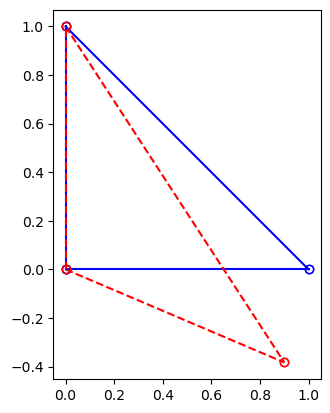

In [25]:
# Create a new figure and axes
fig2, ax2 = plt.subplots()
ax2.set_aspect(1)

# For each one of the elements
for iE,elem in enumerate(Elements):

    # Find Element Nodes
    node1 = elem[0]
    node2 = elem[1]
    
    # Find Node Coordinates
    x1 = Nodes[node1-1,0]
    y1 = Nodes[node1-1,1]
    x2 = Nodes[node2-1,0]
    y2 = Nodes[node2-1,1]
    
    # Find Node Displacements
    U = D[[
        2*(node1-1),
        2*(node1-1)+1,
        2*(node2-1),
        2*(node2-1)+1]]

    # Find New Node Coordinates
    x1d = x1 + magFactor*U[0]
    y1d = y1 + magFactor*U[1]
    x2d = x2 + magFactor*U[2]
    y2d = y2 + magFactor*U[3]

    # Plot a line for the undeformed element
    ax2.plot([x1,x2],[y1,y2], color='blue',marker='o',mfc='none')
    # Plot a line for the undeformed element
    ax2.plot([x1d,x2d],[y1d,y2d], color='red',linestyle='--',marker='o',mfc='none')

You can add code to annotate nodes and elements.